# Comparing SVI and MCMC for linear regression

Simple example comparing SVI (Stochastic Variational Inference) and MCMC in NumPyro using a basic linear regression model.

This example demonstrates both MCMC and SVI on a simple linear regression with just two parameters:

1. `slope`: The coefficient for our linear relationship
2. `sigma`: The observation noise

Key differences between the methods:

* MCMC provides full posterior samples but is typically slower
* SVI gives approximate posterior estimates but is usually faster
* The MCMC output gives us direct samples we can analyze
* SVI gives us parametric distributions (in this case, normal distributions via AutoNormal guide)

In [8]:
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import NUTS, MCMC, SVI, Trace_ELBO, autoguide, Predictive
from jax import random
import jax.numpy as jnp
import matplotlib.pyplot as plt

# Generate synthetic data
def generate_data(N=100, seed=0):
    np.random.seed(seed)
    X = np.random.randn(N)
    true_slope = 2.0
    y = true_slope * X + np.random.randn(N) * 0.5
    return X, y

# Generate synthetic data
X, y = generate_data()

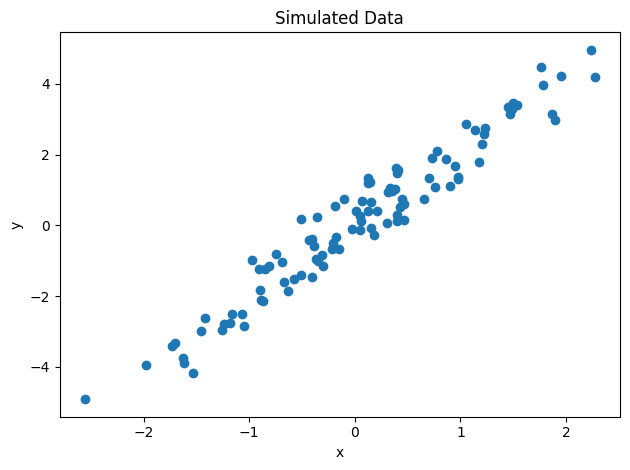

In [9]:
plt.scatter(X, y)
plt.title('Simulated Data')
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()

In [10]:
# Define model with just two parameters: slope and noise
def model(X, y=None):
    # Prior for slope
    slope = numpyro.sample("slope", dist.Normal(0, 10))

    # Prior for observation noise
    sigma = numpyro.sample("sigma", dist.HalfNormal(1))

    # Mean prediction
    mean = slope * X

    # Likelihood
    with numpyro.plate("data", X.shape[0]):
        numpyro.sample("obs", dist.Normal(mean, sigma), obs=y)


In [14]:
# Initialize random key
rng_key = random.PRNGKey(0)
rng_key, rng_key_predict = random.split(rng_key)

# Run MCMC
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=500, num_samples=1000)
mcmc.run(rng_key, X, y)
mcmc_samples = mcmc.get_samples()

# Run SVI
guide = autoguide.AutoNormal(model)
optimizer = numpyro.optim.Adam(step_size=0.01)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
svi_result = svi.run(rng_key, 1000, X, y)
svi_params = svi_result.params


# Draw samples from SVI posterior
num_samples = 1000
predictive = Predictive(guide, params=svi_params, num_samples=num_samples)
svi_samples = predictive(rng_key_predict)

# Print results and compare
print("\nMCMC Results:")
print("slope:", mcmc_samples["slope"].mean(), "±", mcmc_samples["slope"].std())
print("sigma:", mcmc_samples["sigma"].mean(), "±", mcmc_samples["sigma"].std())

print("\nSVI Results (from samples):")
print("slope:", svi_samples["slope"].mean(), "±", svi_samples["slope"].std())
print("sigma:", svi_samples["sigma"].mean(), "±", svi_samples["sigma"].std())

print("\nSVI Results:")
means = guide.median(svi_params)
print("slope:", means["slope"])
print("sigma:", means["sigma"])



100%|██████████| 1000/1000 [00:00<00:00, 1572.40it/s, init loss: 271.8827, avg. loss [951-1000]: 83.6967]



MCMC Results:
slope: 2.0599415 ± 0.05155591
sigma: 0.52372783 ± 0.035647746

SVI Results (from samples):
slope: 2.0508435 ± 0.05153787
sigma: 0.53324866 ± 0.03649885

SVI Results:
slope: 2.0530145
sigma: 0.5316482


The key differences in how we get posterior samples:

* MCMC: Directly produces samples through the sampling process
* SVI: 
    * First fits a parametric distribution (in this case, using AutoNormal guide). 
    * Then we can draw samples from this fitted distribution using the Predictive class

The main trade-offs are:

* SVI samples are drawn from an approximate posterior (usually assuming independence between parameters unless specified otherwise)
* MCMC samples represent the "true" posterior but take longer to generate
* SVI can generate new samples very quickly once fitted

In [17]:
svi_samples.keys()

dict_keys(['sigma', 'slope'])

In [18]:
svi_samples['sigma'].shape

(1000,)